#### Instruction (Read this)
- Use this template to develop your project. Do not change the steps. 
- For each step, you may add additional cells if needed.
- But remove <b>unnecessary</b> cells to ensure the notebook is readable.
- Marks will be <b>deducted</b> if the notebook is cluttered or difficult to follow due to excess or irrelevant content.
- <b>Briefly</b> describe the steps in the "Description:" field.
- <b>Do not</b> submit the dataset. 
- The submitted jupyter notebook will be executed using the uploaded dataset in eLearn.

#### Group Information

Group No: Climate3

- Member 1: Edwin Chia Yi Yang
- Member 2: Hong JingLong
- Member 3: Hong Soon Chuan Jarren
- Member 4: Tan Wei Yi

#### Import libraries

In [14]:
%config Completer.use_jedi=False # comment if not needed
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score, 
    f1_score, confusion_matrix, classification_report, 
    r2_score, mean_squared_error, mean_absolute_error
)
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

#### Load the dataset

In [15]:
# Load the dataset
df = pd.read_csv('climate.csv')

# Check for missing values
print(df.isnull().sum())

# Split the dataset into features and target variable
X = df.drop(columns=['outcome'])
y = df['outcome']

# Label encode the target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

Study                   0
Run                     0
vconst_corr             0
vconst_2                0
vconst_3                0
vconst_4                0
vconst_5                0
vconst_7                0
ah_corr                 0
ah_bolus                0
slm_corr                0
efficiency_factor       0
tidal_mix_max           0
vertical_decay_scale    0
convect_corr            0
bckgrnd_vdc1            0
bckgrnd_vdc_ban         0
bckgrnd_vdc_eq          0
bckgrnd_vdc_psim        0
Prandtl                 0
outcome                 0
dtype: int64


#### Split the dataset
Split the dataset into training, validation and test sets.

In [16]:
# Split the dataset into training, validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.125, random_state=42)  # 0.125 * 0.8 = 0.1

### Data Preprocessing
Perform data preprocessing such as normalization, standardization, and encoding to prepare the dataset for modeling.

### Identifying Numerical and Categorical Columns:
- Numerical Columns Identification: Identifies columns with numerical data types (int64, float64) in the dataset. These columns are stored in the numerical_cols list.
- Categorical Columns Identification: Identifies columns with categorical data types (object) in the dataset. These columns are stored in the categorical_cols list.

### Removing the Target Variable:
- Exclude Target from Features: Ensures the target variable (outcome) is not included in the features list (numerical_cols and categorical_cols). This step is necessary because the target variable should not be used as a feature in the model.

### Defining Transformers:
- Numerical Transformer:

    - Imputation: Missing values in numerical columns are imputed using the mean value of each column.
    - Standardization: Numerical columns are standardized using StandardScaler to have a mean of 0 and a standard deviation of 1.
- Categorical Transformer:

    - Imputation: Missing values in categorical columns are imputed using the most frequent value of each column.
    - Encoding: Categorical columns are converted into numerical format using OneHotEncoder, which creates binary columns for each category.
    
### Combining Transformers into a Preprocessor:
- ColumnTransformer: Combines the numerical and categorical transformers into a single preprocessor. This allows different transformations to be applied to numerical and categorical features within the dataset in a unified manner.

### Applying Transformations:
- Fit and Transform Training Data: The preprocessor is fit on the training data (X_train) and applied to transform it. This step learns the required transformations from the training data and applies them.

- Transform Validation and Test Data: The preprocessor, already fitted on the training data, is applied to the validation (X_val) and test (X_test) datasets to ensure they undergo the same transformations as the training data.

### Standardizing Features:
- StandardScaler: Although standardization is already part of the numerical transformer, an additional standardization step is applied to ensure all features are standardized. This step:
    - Fit and Transform Training Data: Fits the StandardScaler on the training data and transforms it to ensure numerical features have a mean of 0 and a standard deviation of 1.
    - Transform Validation and Test Data: Transforms the validation and test datasets to match the standardized scale of the training data.
    
### Summary
- Numerical Columns: Imputed with mean and standardized.
- Categorical Columns: Imputed with the most frequent value and one-hot encoded.
- Unified Transformation: Uses ColumnTransformer to apply these transformations in a unified manner across the dataset.
- Standardization: Ensures numerical features are standardized across training, validation, and test sets.

In [17]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Ensure 'outcome' is not included in the features
target_variable = 'outcome' 
if 'outcome' in numerical_cols:
    numerical_cols.remove('outcome')
if 'outcome' in categorical_cols:
    categorical_cols.remove('outcome')

# Define transformers for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])


# Apply transformations to the datasets
X_train = preprocessor.fit_transform(X_train)
X_val = preprocessor.transform(X_val)
X_test = preprocessor.transform(X_test)


# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)


### Feature Selection

### Defining Feature Names:
- Feature Names: Lists the names of all the features in the dataset. This is important for understanding the context of the features when evaluating their importance.

### Training a Random Forest Classifier:
- Create and Fit Model: A Random Forest Classifier is created and fitted to the training data. This step is crucial as the model will be used to determine the importance of each feature.

### Evaluating Feature Importances:
- Feature Importances: After training the model, the feature importances are extracted. This array indicates how important each feature is in predicting the target variable.

### Visualizing Feature Importances:
- Visualization: A bar plot is created to visualize the importance of each feature. Features are sorted in descending order of importance, and their names are arranged accordingly for clarity.

### Implementing Feature Selector:
- Feature Selector Class: A custom transformer class, FeatureSelector, is defined. This class selects the top num_features based on their importance scores.

### Applying Feature Selector:
- Select Top Features: The FeatureSelector transformer is instantiated with the calculated feature importances and the desired number of top features. It is then applied to the training, validation, and test datasets to retain only the selected top features.

### Summary
- Feature Names: Provides context for feature importances.
- Training Model: Uses Random Forest to determine feature importances.
- Extract and Sort Importances: Retrieves and sorts feature importances.
- Visualization: Creates a bar plot to visualize the importance of each feature.
- Feature Selection Transformer: Defines a transformer to select top features.
- Apply Feature Selection: Selects and transforms datasets to retain top features.

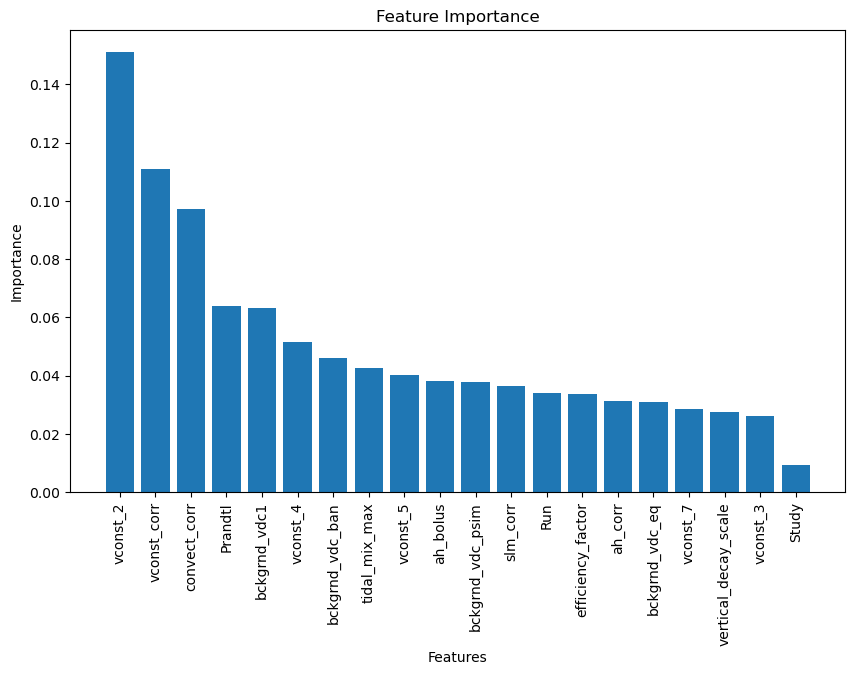

In [18]:
# Feature names
feature_names = ['Study', 'Run', 'vconst_corr', 'vconst_2', 'vconst_3', 'vconst_4', 'vconst_5', 'vconst_7', 'ah_corr', 'ah_bolus', 'slm_corr', 'efficiency_factor', 'tidal_mix_max', 'vertical_decay_scale', 'convect_corr', 'bckgrnd_vdc1', 'bckgrnd_vdc_ban', 'bckgrnd_vdc_eq', 'bckgrnd_vdc_psim', 'Prandtl']

# Create a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Fit the model
rf_model.fit(X_train, y_train)

# Get feature importances
importances = rf_model.feature_importances_

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Rearrange feature names so they match the sorted feature importances
names = [feature_names[i] for i in indices]

# Create plot
plt.figure(figsize=(10, 6))
plt.bar(range(X_train.shape[1]), importances[indices])
plt.xticks(range(X_train.shape[1]), names, rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.show()

class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, num_features):
        self.feature_importances = feature_importances
        self.num_features = num_features
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        # Select top 'num_features' indices
        indices = np.argsort(self.feature_importances)[::-1][:self.num_features]
        return X[:, indices]
    

    # Apply the Feature Selector
num_features = 10  # Choose the number of top features to select
selector = FeatureSelector(importances, num_features)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)
X_test_selected = selector.transform(X_test)

#### Data modeling
Build the machine learning models. You must build atleast two (2) predictive models. One of the predictive models must be either Neural Network or Fuzzy Logic System.
______________________________________________________________________________________
Description: Building Logistic Regression and Neural Network models.


## Logistic Regression Model 
In this section, we define and perform hyperparameter tuning for a Logistic Regression model using GridSearchCV. This involves specifying a range of values for several hyperparameters and using cross-validation to evaluate the model performance for each combination of parameters. 

### Hyperparameters:
- C: The inverse of regularization strength.
- solver: The algorithm to use in the optimization problem.
- fit_intercept: Whether to add a constant (bias or intercept) to the decision function.
- class_weight: Weights associated with classes.
- max_iter: Maximum number of iterations for the solvers to converge.
- multi_class: If the option chosen is 'ovr', then a binary problem is fit for each label, with the option ['ovr'].
- tol: Tolerance for stopping criteria.

### Process
1. Model Initialization: Initialize the LogisticRegression model with a fixed random state for reproducibility.
2. Parameter Grid Definition: Define a dictionary param_grid_lr that includes all hyperparameters and their respective ranges.
3. Grid Search Initialization: Create a GridSearchCV object to perform exhaustive search over the specified parameter grid, using 5-fold cross-validation and the F1 score as the evaluation metric.
4. Model Fitting: Fit the GridSearchCV object on the training data to find the best hyperparameters.
5. Best Model Extraction: Extract the best model (best_log_reg) and print the best hyperparameters found during the search.

In [19]:
log_reg = LogisticRegression(random_state=42)
param_grid_lr = {
    'C': [0.1, 1, 10],
    'solver': ['liblinear', 'lbfgs'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'max_iter': [1000, 2000],
    'multi_class': ['ovr'],
    'tol': [1e-4, 1e-3]
}
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=5, scoring='f1')
grid_search_lr.fit(X_train, y_train)
best_log_reg = grid_search_lr.best_estimator_
print("Best parameters found: ", grid_search_lr.best_params_)

Best parameters found:  {'C': 1, 'class_weight': None, 'fit_intercept': True, 'max_iter': 1000, 'multi_class': 'ovr', 'solver': 'lbfgs', 'tol': 0.0001}


## Neural Network Model
In this section, we perform hyperparameter tuning for a Neural Network model using RandomizedSearchCV. This involves specifying a range of values for several hyperparameters and randomly sampling a fixed number of parameter settings from the specified distributions. The process also includes scaling the data using a pipeline to ensure consistent preprocessing. 

### Hyperparameters:
- hidden_layer_sizes: Number of neurons in the ith hidden layer.
- activation: Activation function for the hidden layer.
- solver: The solver for weight optimization, with options.
- alpha: L2 penalty (regularization term) parameter, uniformly sampled between 0.0001 and 0.1.
- learning_rate: Learning rate schedule for weight updates.
- learning_rate_init: Initial learning rate, uniformly sampled between 0.001 and 0.01.

### Process:
1. Pipeline Creation: Create a pipeline that includes data scaling with StandardScaler followed by the MLPClassifier.
2. Parameter Distributions Definition: Define a dictionary param_dist_mlp that includes all hyperparameters and their respective distributions.
3. Randomized Search Initialization: Create a RandomizedSearchCV object to randomly sample 100 parameter settings from the specified distributions, using 5-fold cross-validation and the F1 score as the evaluation metric. Set n_jobs=-1 to use all available CPU cores and verbose=1 to enable progress updates.
4. Model Fitting: Fit the RandomizedSearchCV object on the training data to find the best hyperparameters.
5. Best Model Extraction: Extract the best model (best_mlp) and print the best hyperparameters found during the search.

In [20]:
# Define parameter distributions for RandomizedSearchCV
param_dist_mlp = {
    'mlp__hidden_layer_sizes': [(50,), (100,), (150,)],
    'mlp__activation': ['tanh', 'relu'],
    'mlp__solver': ['adam', 'lbfgs'],
    'mlp__alpha': uniform(0.0001, 0.1),
    'mlp__learning_rate': ['constant', 'adaptive'],
    'mlp__learning_rate_init': uniform(0.001, 0.01)
}

# Create a pipeline that scales the data then fits the model
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPClassifier(max_iter=2000, random_state=42))
])

# Use RandomizedSearchCV with parallel computation
random_search_mlp = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_dist_mlp, 
    n_iter=100, 
    cv=5, 
    scoring='f1', 
    n_jobs=-1, 
    random_state=42,
    verbose=1  
)

random_search_mlp.fit(X_train, y_train)
best_mlp = random_search_mlp.best_estimator_

print("Best parameters found: ", random_search_mlp.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found:  {'mlp__activation': 'tanh', 'mlp__alpha': 0.0680844779900246, 'mlp__hidden_layer_sizes': (150,), 'mlp__learning_rate': 'constant', 'mlp__learning_rate_init': 0.0033823615240397946, 'mlp__solver': 'lbfgs'}


#### Evaluate the models
Perform a comparison between the predictive models. <br>
Report the accuracy, recall, precision and F1-score measures as well as the confusion matrix if it is a classification problem. <br>
Report the R2 score, mean squared error and mean absolute error if it is a regression problem.
______________________________________________________________________________________
Description: Evaluating models on validation data and reporting performance metrics.


In [21]:
# Logistic Regression Evaluation
y_pred_log_reg = best_log_reg.predict(X_val)
accuracy_log_reg = accuracy_score(y_val, y_pred_log_reg)
recall_log_reg = recall_score(y_val, y_pred_log_reg)
precision_log_reg = precision_score(y_val, y_pred_log_reg)
f1_log_reg = f1_score(y_val, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_val, y_pred_log_reg)

# Neural Network Evaluation
y_pred_mlp = best_mlp.predict(X_val)
accuracy_mlp = accuracy_score(y_val, y_pred_mlp)
recall_mlp = recall_score(y_val, y_pred_mlp)
precision_mlp = precision_score(y_val, y_pred_mlp)
f1_mlp = f1_score(y_val, y_pred_mlp)
conf_matrix_mlp = confusion_matrix(y_val, y_pred_mlp)

In [31]:
# Report the metrics
print('Validating set:')
print("Logistic Regression:")
print(f"Accuracy: {accuracy_log_reg}")
print(f"Recall: {recall_log_reg}")
print(f"Precision: {precision_log_reg}")
print(f"F1 Score: {f1_log_reg}")
print(f"Confusion Matrix:\n {conf_matrix_log_reg}")

print("\nNeural Network:")
print(f"Accuracy: {accuracy_mlp}")
print(f"Recall: {recall_mlp}")
print(f"Precision: {precision_mlp}")
print(f"F1 Score: {f1_mlp}")
print(f"Confusion Matrix:\n {conf_matrix_mlp}")

Validating set:
Logistic Regression:
Accuracy: 0.9629629629629629
Recall: 1.0
Precision: 0.9607843137254902
F1 Score: 0.98
Confusion Matrix:
 [[ 3  2]
 [ 0 49]]

Neural Network:
Accuracy: 0.9629629629629629
Recall: 1.0
Precision: 0.9607843137254902
F1 Score: 0.98
Confusion Matrix:
 [[ 3  2]
 [ 0 49]]


## Comparison of the Validation Set between Two Predictive Models

Since we are work on classification problem, thus we will compare the result using the accuracy, recall, precision, F1 score as well as confision metrics:

### Accuracy: 
Both models have the same high accuracy of 96.3%, indicating that they correctly classify the vast majority of instances.

### Recall: 
Both models have perfect recall (1.0) for the positive class (1), meaning they correctly identified all positive instances.

### Precision: 
The precision for the positive class (1) is 0.96 for both models, indicating that most of the instances classified as positive are indeed positive.

### F1 Score: 
The F1 score for the positive class (1) is 0.98 for both models, which is a balance between precision and recall.

### Confusion Matrix:
Confusion matrix are also identical for both models with the following results:
True Positives (TP): 49 (correctly classified as class 1)
True Negatives (TN): 3 (correctly classified as class 0)
False Positives (FP): 2 (incorrectly classified as class 1)
False Negatives (FN): 0 (incorrectly classified as class 0)

### Classification Report:
Both models perform identically across all metrics in the classification report. This indicates that their performance on the validation set is equivalent

### Comparison & Justification
Both the Logistic Regression and Neural Network models have shown identical performance across all key metrics (accuracy, recall, precision, and F1 score) on the validation set. This indicates that, given the current dataset and its characteristics, both models are equally effective in classifying the target variable.

Given the identical performance of both models, the choice between Logistic Regression and Neural Networks should consider additional factors such as interpretability, computational resources, and deployment ease. Logistic Regression offers simplicity and interpretability, making it a strong candidate for many applications. On the other hand, Neural Networks provide flexibility and the ability to model complex relationships, which might be beneficial for more intricate datasets. Further validation and exploration of ensemble methods and advanced feature engineering could provide deeper insights and potentially improve model performance.

In [24]:
# Logistic Regression Test Set Evaluation
# Make predictions on the test set using the Logistic Regression model
y_pred_log_reg_test = best_log_reg.predict(X_test)

# Calculate evaluation metrics for Logistic Regression on the test set
accuracy_log_reg_test = accuracy_score(y_test, y_pred_log_reg_test)  # Accuracy
recall_log_reg_test = recall_score(y_test, y_pred_log_reg_test)  # Recall
precision_log_reg_test = precision_score(y_test, y_pred_log_reg_test)  # Precision
f1_log_reg_test = f1_score(y_test, y_pred_log_reg_test)  # F1 Score
conf_matrix_log_reg_test = confusion_matrix(y_test, y_pred_log_reg_test)  # Confusion Matrix

# Neural Network Test Set Evaluation
# Make predictions on the test set using the Neural Network model
y_pred_mlp_test = best_mlp.predict(X_test)

# Calculate evaluation metrics for Neural Network on the test set
accuracy_mlp_test = accuracy_score(y_test, y_pred_mlp_test)  # Accuracy
recall_mlp_test = recall_score(y_test, y_pred_mlp_test)  # Recall
precision_mlp_test = precision_score(y_test, y_pred_mlp_test)  # Precision
f1_mlp_test = f1_score(y_test, y_pred_mlp_test)  # F1 Score
conf_matrix_mlp_test = confusion_matrix(y_test, y_pred_mlp_test)  # Confusion Matrix

In [25]:
# Report Test Set Metrics
print("Test Set Evaluation:\n")

print("Logistic Regression:")
print(f"Accuracy: {accuracy_log_reg_test}")
print(f"Recall: {recall_log_reg_test}")
print(f"Precision: {precision_log_reg_test}")
print(f"F1 Score: {f1_log_reg_test}")
print(f"Confusion Matrix:\n {conf_matrix_log_reg_test}")

print("\nNeural Network:")
print(f"Accuracy: {accuracy_mlp_test}")
print(f"Recall: {recall_mlp_test}")
print(f"Precision: {precision_mlp_test}")
print(f"F1 Score: {f1_mlp_test}")
print(f"Confusion Matrix:\n {conf_matrix_mlp_test}")

Test Set Evaluation:

Logistic Regression:
Accuracy: 0.9351851851851852
Recall: 0.9693877551020408
Precision: 0.9595959595959596
F1 Score: 0.964467005076142
Confusion Matrix:
 [[ 6  4]
 [ 3 95]]

Neural Network:
Accuracy: 0.9351851851851852
Recall: 0.9489795918367347
Precision: 0.9789473684210527
F1 Score: 0.9637305699481866
Confusion Matrix:
 [[ 8  2]
 [ 5 93]]


## Comparison of the Testing Set between Two Predictive Models

Since we are work on classification problem, thus we will compare the result using the accuracy, recall, precision, F1 score as well as confision metrics:

### Accuracy: 
Both models have the same accuracy of 0.9352, indicating they correctly classified the same proportion of samples

### Recall: 
Logistic Regression has a slightly higher recall, meaning it was slightly better at identifying positive cases (True Positives)

### Precision: 
The Neural Network has a higher precision, indicating fewer false positives compared to Logistic Regression.

### F1 Score: 
Both models have nearly identical F1 Scores, indicating a balance between precision and recall.

### Confusion Matrix:
Logistic Regression has fewer false negatives (3) compared to the Neural Network (5), meaning it missed fewer positive cases.
Neural Network has fewer false positives (2) compared to Logistic Regression (4), meaning it incorrectly classified fewer negative cases as positive.


### Comparison & Justification: 
Both models exhibit very similar performance across all metrics on the test set, suggesting that they are equally effective at handling the given classification problem. The slight differences in recall and precision balance each other out, leading to nearly identical F1 Scores and overall accuracy.

However, there do have some specific strengths for both logistic egression model and neural network model for this context：
For logistic regression, higher recall suggests it is slightly better at detecting all positive cases, making it useful in applications where missing a positive case is costly.
Slightly higher false positive rate may be acceptable in contexts where the cost of a false positive is lower than a false negative.

For neural network, higher precision suggests it is slightly better at ensuring that positive classifications are correct, making it useful in applications where the cost of false positives is high.
Slightly higher false negative rate may be acceptable in contexts where missing a positive case is less critical than incorrectly classifying a negative case.

In general, logistic regression is suitable if the primary concern is to minimize the false negetives and ensure all positive cases are detected while neural network is suitable when the primary concern is to minimize the false positives and ensure that positive classifications is truely positive.